# Binary Prediction of Poisonous Mushrooms

In [ ]:
# from google.colab import files
# files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"zafermesutblen","key":"995425ec3b85ccd5b3968c2fab0c6f1b"}'}

In [ ]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# !pip install -q kaggle

In [ ]:
# !kaggle competitions download -c playground-series-s4e8

playground-series-s4e8.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# !unzip playground-series-s4e8.zip

Archive:  playground-series-s4e8.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [6]:
!pip install -q ucimlrepo

In [7]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import warnings

from ucimlrepo import fetch_ucirepo

pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")

In [8]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
original = fetch_ucirepo(id=848)['data']['original']

## EDA - Exploratory Data Analysis

In [9]:
train.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,4.51,15.39,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,4.79,6.48,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,6.85,9.93,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,4.16,6.53,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,3.37,8.36,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [10]:
categorical_features = train.select_dtypes(include='object').columns.tolist()
categorical_features.remove('class')
numerical_features = train.select_dtypes(exclude='object').columns.tolist()

df_numerical = pd.DataFrame({'Numerical Variables': numerical_features})
df_categorical = pd.DataFrame({'Categorical Variables': categorical_features})

In [11]:
df_numerical

,Numerical Variables
0,id
1,cap-diameter
2,stem-height
3,stem-width


In [12]:
df_categorical

,Categorical Variables
0,cap-shape
1,cap-surface
2,cap-color
3,does-bruise-or-bleed
4,gill-attachment
5,gill-spacing
6,gill-color
7,stem-root
8,stem-surface
9,stem-color


In [13]:
train.isna().sum()

,0
id,0
class,0
cap-diameter,4
cap-shape,40
cap-surface,671023
cap-color,12
does-bruise-or-bleed,8
gill-attachment,523936
gill-spacing,1258435
gill-color,57


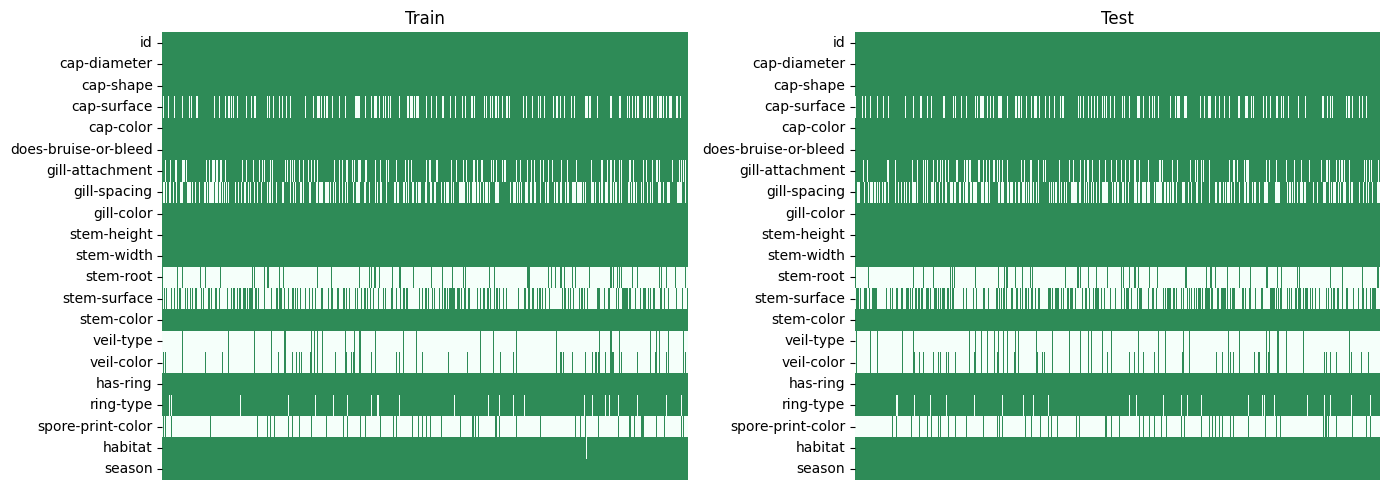

In [14]:
# Custom color palette
custom_palette = ['#2E8B57', '#98FB98', '#8B4513', '#2E8B57', '#556B2F', '#8FBC8F', '#F5FFFA']

# Create a custom colormap
cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_palette, N=256)

# Sample data for null values heatmap
train_null_values = train.sample(100_000).drop(columns=['class']).isnull().T
test_null_values = test.sample(100_000).isnull().T

# Plotting the heatmaps
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

sns.heatmap(train_null_values, cbar=False, cmap=cmap, ax=axes[0])
axes[0].set_title('Train')
axes[0].set_xticks([])
axes[0].set_xlabel('')

sns.heatmap(test_null_values, cbar=False, cmap=cmap, ax=axes[1])
axes[1].set_title('Test')
axes[1].set_xticks([])
axes[1].set_xlabel('')

plt.tight_layout()
plt.show()

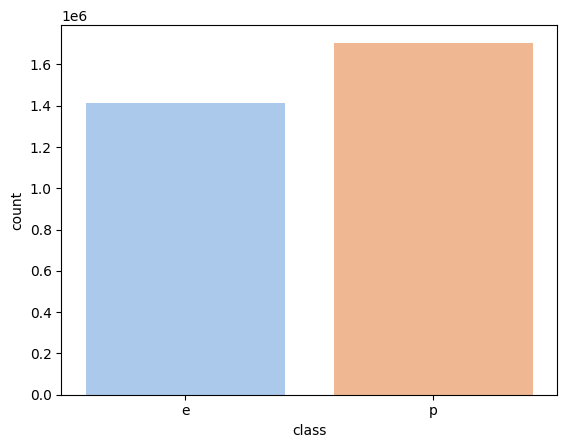

In [15]:
sns.countplot(x=train['class'], palette="pastel");

In [16]:
features = train.drop('class', axis=1).columns.to_list()

features_with_high_null_values = [feature for feature in features if (train[feature].isna().sum()/len(train)*100)>20]
df_features_high_null = pd.DataFrame(features_with_high_null_values, columns=['Features With High Null Values'])

df_features_high_null

,Features With High Null Values
0,cap-surface
1,gill-spacing
2,stem-root
3,stem-surface
4,veil-type
5,veil-color
6,spore-print-color


## Feature Engineering

In [17]:
cat_features = test.select_dtypes('object').columns

In [18]:
# Reference: https://www.kaggle.com/code/ambrosm/pss4e8-eda-which-makes-sense

for feature in cat_features:
    categories = sorted(list(set(original[feature].dropna())))
    dtype = pd.CategoricalDtype(categories=categories, ordered=False)

    train.loc[~train[feature].isin(categories), feature] = np.nan
    test.loc[~test[feature].isin(categories), feature] = np.nan

    train[feature] = train[feature].astype(dtype)
    test[feature] = test[feature].astype(dtype)

In [19]:
X = train
X = X.drop(["class"], axis="columns")
y = train["class"].map({'e': 0, 'p': 1})
X_test = test

In [20]:
y.head()

,class
0,0
1,1
2,0
3,0
4,0


In [21]:
# One-hot encode categorical features
X = pd.get_dummies(X)
X_test = pd.get_dummies(X_test)

# Align the columns of the test set with the train set
X_test = X_test.reindex(columns=X.columns, fill_value=0)

In [22]:
!pip install catboost xgboost lightgbm

In [23]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool

from sklearn.metrics import matthews_corrcoef

N_FOLDS = 5
SEED = 6
ES_ROUNDS = 100
ES_LOG_STEPS = 100
THRESHOLD = 0.506

In [24]:
xgb_params = {
    "colsample_bylevel": 0.9268202748354142,
    "colsample_bynode": 0.9584021138317574,
    "colsample_bytree": 0.5015612007146208,
    "early_stopping_rounds": ES_ROUNDS,
    "enable_categorical": True,
    "gamma": 0.3707206931090372,
    "grow_policy": "lossguide",
    "learning_rate": 0.03906159386409017,
    "max_depth": 16,
    "min_child_weight": 0.6117236350232369,
    "n_estimators": 5000,
    "n_jobs": -1,
    "random_state": SEED,
    "reg_alpha": 1.7264475728199302,
    "reg_lambda": 94.37990118781973,
    "subsample": 0.7599216762241778,
    "tree_method": "hist",
    "verbosity": 0
}

lgbm_params = {

    'colsample_bytree': 0.49938653455911297,
    'learning_rate': 0.019616165942899312,
    'max_bin': 2249,
    'min_child_samples': 156,
    'n_estimators': 5000,
    'n_jobs': -1,
    'num_leaves': 590,
    'random_state': SEED,
    'reg_alpha': 0.416272935775317,
    'reg_lambda': 86.59005784540076,
    'subsample': 0.7495711298182588,
    'verbose': -1
}

catb_params = {
    'iterations': 2500,
    'depth': 10,
    'l2_leaf_reg': 80,
    'verbose': 0
}

xgb_model = XGBClassifier(**xgb_params)
lgbm_model = LGBMClassifier(**lgbm_params)
catb_model = CatBoostClassifier(**catb_params)

# xgb_models = [(f"xgb_{i}", XGBClassifier(**{**xgb_params, "random_state": i})) for i in range(9)]
# lgb_models = [(f"lgb_{i}", LGBMClassifier(**{**lgbm_params, "random_state": i})) for i in range(12)]
# catb_models = [(f"cat_{i}", CatBoostClassifier(**{**catb_params, "random_state": i})) for i in range(5)]

In [25]:
# all_models = [['lgbm_model',lgbm_model],['catb_model',catb_model],]

# test_pred_probas = []

# for name, model in all_models:
#     model.fit(X, y)
#     train_preds = model.predict(X)
#     mcc = matthews_corrcoef(y, train_preds)
#     print(f'Training Data -> Model: {name}, MCC: {round(mcc, 5)}')
#     print()
#     test_pred_probas.append(model.predict_proba(X_test)[:, 1])

# print()
# print('Done !!')

In [ ]:
lgbm_model.fit(X, y)
train_preds = lgbm_model.predict(X)
mcc = matthews_corrcoef(y, train_preds)
print(f'Training Data -> Model: lgbm_model, MCC: {round(mcc, 5)}')

In [27]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model.fit(X,y)
train_preds = rf_model.predict(X)
mcc = matthews_corrcoef(y, train_preds)
print(f'Training Data -> Model: rf_model, MCC: {round(mcc, 5)}')

Training Data -> Model: rf_model, MCC: 0.99997


In [28]:
#save rf_model
import pickle
pickle.dump(rf_model, open('rf_model.pkl', 'wb'))

In [31]:
submission = pd.read_csv("sample_submission.csv")
submission['class'] = rf_model.predict(X_test)
submission['class'] = submission['class'].map({0: 'e', 1: 'p'})
submission

,id,class
0,3116945,e
1,3116946,p
2,3116947,p
3,3116948,p
4,3116949,e
...,...,...
2077959,5194904,p
2077960,5194905,p
2077961,5194906,p
2077962,5194907,e


In [32]:
submission.to_csv('submission_rf.csv', index=False)